In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector, SparsePauliOp, Operator
from qiskit.circuit import Gate
from scipy.optimize import minimize
from scipy.stats import norm

#############################
## 1) PDE Setup + Helpers  ##
#############################

def black_scholes_call(S, t, K, T, sigma, r):
    if S <= 1e-12:
        return 0.0
    tau = T - t
    if tau <= 0:
        return max(S - K, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma * math.sqrt(tau)
    return S * norm.cdf(d1) - K * math.exp(-r * tau) * norm.cdf(d2)

def scale_point(x_s, domain_bounds):
    scaled = []
    for i, val in enumerate(x_s):
        lb, ub = domain_bounds[i]
        scaled_val = 2.0 * (val - (lb + ub) / 2.) / (ub - lb)
        scaled.append(scaled_val)
    return scaled

##############################
## 2) Chebyshev + decode_index
##############################

def decode_index(i, l_list):
    n = sum(l_list)
    sign_bit = (i >> n) & 1
    i_order_bits = i & ((1 << n) - 1)
    orders = []
    for l_j in l_list:
        mask = (1 << l_j) - 1
        order_j = i_order_bits & mask
        orders.append(order_j)
        i_order_bits >>= l_j
    return sign_bit, orders

def chebyshev_polynomial(order, x):
    if order == 0:
        return np.ones_like(x)
    elif order == 1:
        return x
    else:
        T_prev = np.ones_like(x)
        T_curr = x
        for n in range(2, order + 1):
            T_next = 2. * x * T_curr - T_prev
            T_prev, T_curr = T_curr, T_next
        return T_curr

def chebyshev_derivative(order, q, x):
    if q == 0:
        return chebyshev_polynomial(order, x)
    if order < q:
        return np.zeros_like(x)
    result = np.zeros_like(x)
    for k in range(0, order - q + 1, 2):
        numerator = math.factorial((order + q - k) // 2 - 1)
        denominator = math.factorial((order - q - k) // 2)
        coeff = (2 ** q) * order * (numerator / denominator)
        result += coeff * chebyshev_polynomial(k, x)
    if (order - q) % 2 == 0:
        result /= 2
    return result

def multivariate_chebyshev(i, x_scaled, l_list):
    sign_bit, orders = decode_index(i, l_list)
    sign_factor = 1 if sign_bit == 0 else -1
    val = sign_factor
    for (ord_j, x_j) in zip(orders, x_scaled):
        val *= chebyshev_polynomial(ord_j, x_j)
    return val

def multivariate_chebyshev_derivative(i, x_scaled, var_idx, q, l_list):
    sign_bit, orders = decode_index(i, l_list)
    sign_factor = 1 if sign_bit == 0 else -1
    order_var = orders[var_idx]
    d_val = chebyshev_derivative(order_var, q, x_scaled[var_idx])
    for j, (ord_j, x_j) in enumerate(zip(orders, x_scaled)):
        if j != var_idx:
            d_val *= chebyshev_polynomial(ord_j, x_j)
    return sign_factor * d_val

##############################
## 3) Qiskit circuit builder
##############################

def to_quantum_circuit(U):
    if isinstance(U, QuantumCircuit):
        return U
    elif isinstance(U, Gate):
        qc = QuantumCircuit(U.num_qubits)
        qc.append(U, range(U.num_qubits))
        return qc
    elif isinstance(U, (Operator, SparsePauliOp)):
        n = U.num_qubits
        qc = QuantumCircuit(n)
        qc.append(U.to_instruction(), range(n))
        return qc
    elif isinstance(U, Statevector):
        n = U.num_qubits
        qc = QuantumCircuit(n)
        qc.initialize(U.data, range(n))
        return qc
    else:
        raise TypeError("Unsupported type for conversion to QuantumCircuit.")

def get_probas(ansatz):
    qc = to_quantum_circuit(ansatz)
    psi = Statevector.from_instruction(qc)
    return np.abs(psi.data) ** 2

def _create_variational_circuit_cached(n_qubits, theta_params_tuple, depth, entanglement_type="full"):
    rotation_blocks = ["ry"]
    entanglement_blocks = "cz"
    variational_form = TwoLocal(
        n_qubits,
        rotation_blocks=rotation_blocks,
        entanglement_blocks=entanglement_blocks,
        entanglement=entanglement_type,
        reps=depth,
        parameter_prefix="θ"
    )
    needed_len = (depth + 1) * n_qubits * len(rotation_blocks)
    if len(theta_params_tuple) != needed_len:
        raise ValueError(f"Parameter length mismatch. Expected {needed_len}, got {len(theta_params_tuple)}")
    qc = QuantumCircuit(n_qubits)
    qc = qc.compose(variational_form)
    param_dict = dict(zip(qc.parameters, theta_params_tuple))
    qc = qc.assign_parameters(param_dict)
    return qc

def create_variational_circuit(n_qubits, theta_params, depth, entanglement_type="full"):
    if isinstance(theta_params, np.ndarray):
        theta_params_tuple = tuple(theta_params.flatten())
    else:
        theta_params_tuple = tuple(theta_params)
    return _create_variational_circuit_cached(n_qubits, theta_params_tuple, depth, entanglement_type)

def construct_observable(x_scaled, l_list):
    n = sum(l_list)
    half_size = 2 ** (n - 1)
    diagonal_elements = []
    for i in range(half_size):
        cheb_val = multivariate_chebyshev(i, x_scaled, l_list)
        diagonal_elements.append(cheb_val)
    diagonal_elements += [-val for val in diagonal_elements]
    observable = np.diag(diagonal_elements)
    return observable

##############################
## 4) PDE solution f(x)
##############################

def compute_core_g(x, n_qubits, ansatz, lambda_scale=1.0, domain_bounds=None, l_list=None):
    if domain_bounds is not None:
        x_scaled = scale_point(x, domain_bounds)
    else:
        x_scaled = x
    probas = get_probas(ansatz)
    half_size = 2 ** (n_qubits - 1)
    g_x = 0.0
    for i in range(half_size):
        coeff = probas[i] - probas[i + half_size]
        poly_val = multivariate_chebyshev(i, x_scaled, l_list)
        g_x += coeff * poly_val
    return lambda_scale * g_x

def embedding_phi_S(S, S_max):
    return S / S_max

def compute_solution_f_v2(x, n_qubits, ansatz, lambda_scale, domain_bounds, l_list):
    g_val = compute_core_g(x, n_qubits, ansatz, lambda_scale, domain_bounds, l_list)
    S_val = x[0]
    S_min, S_max = domain_bounds[0]
    phi_s = embedding_phi_S(S_val, S_max)
    f_val = phi_s * g_val
    return f_val

##############################
## 5) PDE residual w/chain
##############################

def compute_L_diff(x_samples, sigma, r, lambda_scale,
                   n_qubits, ansatz, domain_bounds, l_list):

    probas     = get_probas(ansatz)
    half_size  = 2 ** (n_qubits - 1)
    n_s        = len(x_samples)

    # --- NEW: metric-to-physical conversion factors ------------------------
    c_S = 2.0 / (domain_bounds[0][1] - domain_bounds[0][0])   # dSscaled/dS
    c_t = 2.0 / (domain_bounds[1][1] - domain_bounds[1][0])   # dtScaled/dt
    # -----------------------------------------------------------------------

    L_diff = 0.0
    for x_s in x_samples:
        x_scaled = scale_point(x_s, domain_bounds)

        g_scl = dgS_scl = d2gS2_scl = dgT_scl = 0.0

        # ----- build g and its Chebyshev derivatives in scaled coords -------
        for i in range(half_size):
            coeff            = probas[i] - probas[i + half_size]
            T_val            = multivariate_chebyshev(i, x_scaled, l_list)
            dT_dSscaled      = multivariate_chebyshev_derivative(i, x_scaled, 0, 1, l_list)
            d2T_dSscaled2    = multivariate_chebyshev_derivative(i, x_scaled, 0, 2, l_list)
            dT_dtScaled      = multivariate_chebyshev_derivative(i, x_scaled, 1, 1, l_list)

            g_scl     += coeff * T_val
            dgS_scl   += coeff * dT_dSscaled
            d2gS2_scl += coeff * d2T_dSscaled2
            dgT_scl   += coeff * dT_dtScaled

        # apply global scale λ
        g_scl     *= lambda_scale
        dgS_scl   *= lambda_scale
        d2gS2_scl *= lambda_scale
        dgT_scl   *= lambda_scale

        # ----------- convert derivatives to PHYSICAL units ------------------
        dgS   = dgS_scl   * c_S
        d2gS2 = d2gS2_scl * (c_S ** 2)
        dgT   = dgT_scl   * c_t
        # --------------------------------------------------------------------

        # ------------------- chain rule for  f = φ(S) * g -------------------
        S_val      = x_s[0]
        S_min, S_max = domain_bounds[0]
        phi_s      = S_val / S_max          # φ(S)
        dphi_dS    = 1.0 / S_max            # φ'(S)
        # φ''(S) is zero because φ is linear
        f_val      = phi_s * g_scl

        df_dS      = dphi_dS * g_scl + phi_s * dgS
        d2f_dS2    = 2.0 * dphi_dS * dgS + phi_s * d2gS2
        df_dt      = phi_s * dgT            # φ does not depend on t
        # --------------------------------------------------------------------

        # ----------------- Black-Scholes residual on **f** -------------------
        e_xs = (-df_dt
                + 0.5 * sigma ** 2 * S_val ** 2 * d2f_dS2
                + r * S_val * df_dS
                - r * f_val)
        # --------------------------------------------------------------------

        L_diff += e_xs ** 2

    return L_diff / n_s

def compute_L_BC(boundary_points, sigma, r, lambda_scale, n_qubits, ansatz, domain_bounds, l_list):
    if not boundary_points:
        raise ValueError("Boundary points cannot be empty.")
    L_BC = 0.0
    n_bc = len(boundary_points)
    for x_bc, f_bc in boundary_points.items():
        f_val = compute_solution_f_v2(x_bc, n_qubits, ansatz, lambda_scale, domain_bounds, l_list)
        L_BC += (f_val - f_bc) ** 2
    return L_BC / n_bc

##############################
## 6) Optimize w/callback
##############################

def optimize_ansatz(
    x_samples, boundary_points, sigma, r, initial_lambda,
    n_qubits, depth, eta=10.0, max_iter=10, domain_bounds=None, l_list=None
):
    if l_list is None or sum(l_list) + 1 != n_qubits:
        raise ValueError("Bad qubit config.")
    if sigma < 0 or r < 0 or initial_lambda < 0:
        raise ValueError("Parameters must be non-negative.")
    
    # Initialize parameters
    num_theta = (depth + 1) * n_qubits  # Correct number of circuit parameters
    initial_theta = np.random.uniform(0, 2 * np.pi, num_theta)  # 15 parameters for depth=2, n_qubits=5
    initial_params = np.append(initial_theta, initial_lambda)  # Add lambda as the last parameter
    
    def build_ansatz(params):
        theta = params[:-1]  # Exclude lambda
        return create_variational_circuit(n_qubits, theta, depth)
    
    def objective(params):
        theta, lambda_ = params[:-1], params[-1]  # Split into theta (15) and lambda (1)
        ans = build_ansatz(params)
        Ld = compute_L_diff(x_samples, sigma, r, lambda_, n_qubits, ans, domain_bounds, l_list)
        Lb = compute_L_BC(boundary_points, sigma, r, lambda_, n_qubits, ans, domain_bounds, l_list)
        return Ld + eta * Lb
    
    history = []
    def callback_f(params):
        theta, lambda_ = params[:-1], params[-1]
        ans = build_ansatz(params)
        Ld = compute_L_diff(x_samples, sigma, r, lambda_, n_qubits, ans, domain_bounds, l_list)
        Lb = compute_L_BC(boundary_points, sigma, r, lambda_, n_qubits, ans, domain_bounds, l_list)
        val = Ld + eta * Lb
        print(f"[Callback] L_diff={Ld:.4f}, L_BC={Lb:.4f}, total={val:.4f}")
        history.append((Ld, Lb, val))
    
    res = minimize(objective, initial_params, method="BFGS", callback=callback_f,
                   options={"maxiter": max_iter, "disp": True})
    return {
        "optimized_params": res.x,
        "final_loss": res.fun,
        "success": res.success,
        "message": res.message,
        "history": history,
        "eta": eta
    }

##############################
## 7) MAIN example usage
##############################
def generate_sample_points_adaptive(
    S_min, S_max, t_min, t_max, n_coarse, n_fine, K, fine_radius=1.0
):
    """
    Generate PDE sample points adaptively.
    """
    # Validate inputs
    if n_coarse <= 0 or n_fine <= 0:
        raise ValueError("n_coarse and n_fine must be positive.")
    if S_min >= S_max or t_min >= t_max:
        raise ValueError("Domain bounds must satisfy S_min < S_max and t_min < t_max.")

    # Coarse grid in S
    S_coarse = np.linspace(S_min, S_max, n_coarse)

    # Fine grid near K
    left = max(S_min, K - fine_radius)
    right = min(S_max, K + fine_radius)
    S_fine = np.linspace(left, right, n_fine)

    # Combine grids and remove duplicates
    S_all = np.unique(np.concatenate([S_coarse, S_fine]))

    # Time grid
    t_vals = np.linspace(t_min, t_max, n_coarse)

    # Cartesian product of S and t
    sample_points = np.array([[S, t] for S in S_all for t in t_vals])

    return sample_points



[Callback] L_diff=1.3614, L_BC=3.1325, total=32.6869
[Callback] L_diff=11.2797, L_BC=1.4962, total=26.2419
[Callback] L_diff=5.0231, L_BC=0.9542, total=14.5654
[Callback] L_diff=1.8742, L_BC=0.2852, total=4.7265
[Callback] L_diff=0.4790, L_BC=0.3455, total=3.9344
[Callback] L_diff=0.5755, L_BC=0.2123, total=2.6985
[Callback] L_diff=0.1259, L_BC=0.1683, total=1.8085
[Callback] L_diff=0.1084, L_BC=0.1620, total=1.7287
[Callback] L_diff=0.0745, L_BC=0.1242, total=1.3164
[Callback] L_diff=0.1940, L_BC=0.0759, total=0.9529
[Callback] L_diff=0.1827, L_BC=0.0390, total=0.5725
[Callback] L_diff=0.0631, L_BC=0.0372, total=0.4351
[Callback] L_diff=0.0614, L_BC=0.0253, total=0.3145
[Callback] L_diff=0.0460, L_BC=0.0229, total=0.2747
[Callback] L_diff=0.0159, L_BC=0.0219, total=0.2348
[Callback] L_diff=0.0067, L_BC=0.0211, total=0.2175
[Callback] L_diff=0.0055, L_BC=0.0201, total=0.2068
[Callback] L_diff=0.0138, L_BC=0.0185, total=0.1992
[Callback] L_diff=0.0142, L_BC=0.0180, total=0.1939
[Callbac

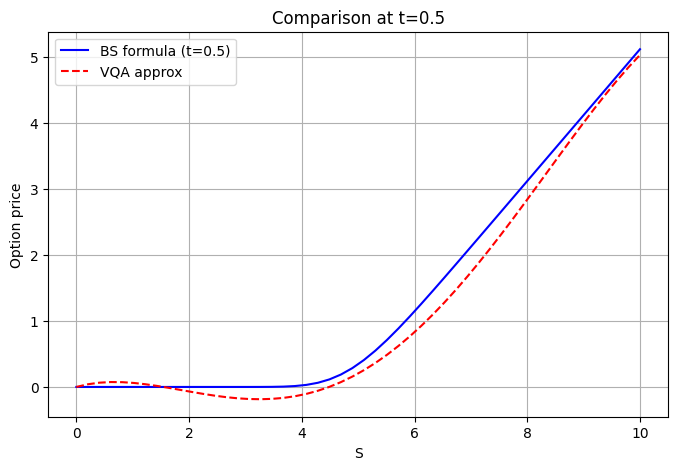

In [4]:
if __name__ == "__main__":
    S_min, S_max = 0, 10
    t_min, t_max = 0, 1.0
    domain_bounds = [(S_min, S_max), (t_min, t_max)]
    sigma = 0.2
    r = 0.05
    K = 5
    T = 1.0
    n_qubits = 5
    depth = 3
    l_list = [2, 2]
    initial_lambda = 10.0
    x_samples = generate_sample_points_adaptive(
        S_min=0, S_max=10, t_min=0, t_max=1,
        n_coarse=10, n_fine=20, K=5, fine_radius=1.0
    )
    boundary_points = {}
    for t_ in np.linspace(0, 1, 10):
        boundary_points[(0, t_)] = 0.0
        boundary_points[(10, t_)] = 10.0 - K * np.exp(-r * (1 - t_))
    for s_ in np.linspace(0, 10, 20):
        boundary_points[(s_, 1.0)] = max(s_ - K, 0)
    result = optimize_ansatz(
        x_samples, boundary_points, sigma, r, initial_lambda,
        n_qubits, depth, eta=10.0, max_iter=75,
        domain_bounds=domain_bounds, l_list=l_list
    )
    final_params = result["optimized_params"]
    final_theta = final_params[:-1]
    final_lambda = final_params[-1]
    print(f"Optimized lambda: {final_lambda:.4f}")
    final_ansatz = create_variational_circuit(n_qubits, final_theta, depth)
    test_points = generate_sample_points_adaptive(
        S_min=0, S_max=10, t_min=0, t_max=1,
        n_coarse=20, n_fine=40, K=5, fine_radius=1.0
    )
    L_diff_final = compute_L_diff(test_points, sigma, r, final_lambda, n_qubits, final_ansatz, domain_bounds, l_list)
    print(f"Final PDE Residual: {L_diff_final:.6f}")
    S_plot = np.linspace(0, 10, 50)
    vqa_vals = [compute_solution_f_v2([S_, 0.5], n_qubits, final_ansatz, final_lambda, domain_bounds, l_list) for S_ in S_plot]
    bs_vals = [black_scholes_call(S_, 0.5, K, T, sigma, r) for S_ in S_plot]
    plt.figure(figsize=(8, 5))
    plt.plot(S_plot, bs_vals, "b-", label="BS formula (t=0.5)")
    plt.plot(S_plot, vqa_vals, "r--", label="VQA approx")
    plt.xlabel("S")
    plt.ylabel("Option price")
    plt.title("Comparison at t=0.5")
    plt.grid(True)
    plt.legend()
    plt.show()